# Load fundamental modules & initialize variables

In [1]:
# Standard library imports
from collections import OrderedDict as od
from glob import glob
from importlib import reload
import inspect
import itertools
import os
import os.path as op
import random
import sys
from time import time
import warnings

# Third party imports
import h5py
import matplotlib as mpl # plotting
from matplotlib.lines import Line2D # plotting
import matplotlib.patches as patches # plotting
import matplotlib.pyplot as plt # plotting
import matplotlib.gridspec as gridspec  # plotting
import numpy as np # functions to analyze and manipulate arrays & matrices
import pandas as pd # dataframes
import scipy.interpolate as interp # scientific computation 
import scipy.io as sio # scientific computation 
import scipy.stats as stats # scientific computation 
import scipy.ndimage as ndi
import seaborn as sns # plotting
from sklearn.decomposition import PCA # tools for machine learning and statistical modeling. Useful for predictions of unobserved values.
import statsmodels.api as sm # tools for statistical analysis. Useful for statistical inference and statistical hypothesis testing.
from statsmodels.formula.api import ols

# Local application imports
sys.path.append('/home1/cjmac/code/general')
sys.path.append('/home1/cjmac/code/manning_replication')
sys.path.append('/home1/cjmac/code/projects/')
import array_operations as aop # for coding
import data_io as dio # for coding
from eeg_plotting import plot_trace, plot_trace2 #plotting
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, trial_phase_analysis # processing eeg data

# Initializing commands
%matplotlib inline
warnings.filterwarnings( 'ignore' )
pd.options.display.max_rows = 500
pd.options.display.max_columns = 999

# Plotting parameters
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42
# warnings.filterwarnings( 'default' )

# Plotting colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
# Plotting font
font = {'tick': 12,
        'label': 14,
        'fig': 16}

## Perform alignment (or not)

The first timestamp in events before zero-ing is 1654735168087.340
The first timestamp in events after zero-ing is 0.000
143295 events recorded over 78 min and 57 sec
The first timestamp in lfp_timestamps before zero-ing & before conv factor is 1654709925.092
The first timestamp in lfp_timestamps before zero-ing & after conv factor is 1654709925091.791
The first timestamp in lfp_timestamps after zero-ing & conv factor is 0.000
Conversion factor is 1000.0
153210591 timestamps over 79 min and 47.8 s
Sampling rate is 32000 Hz


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


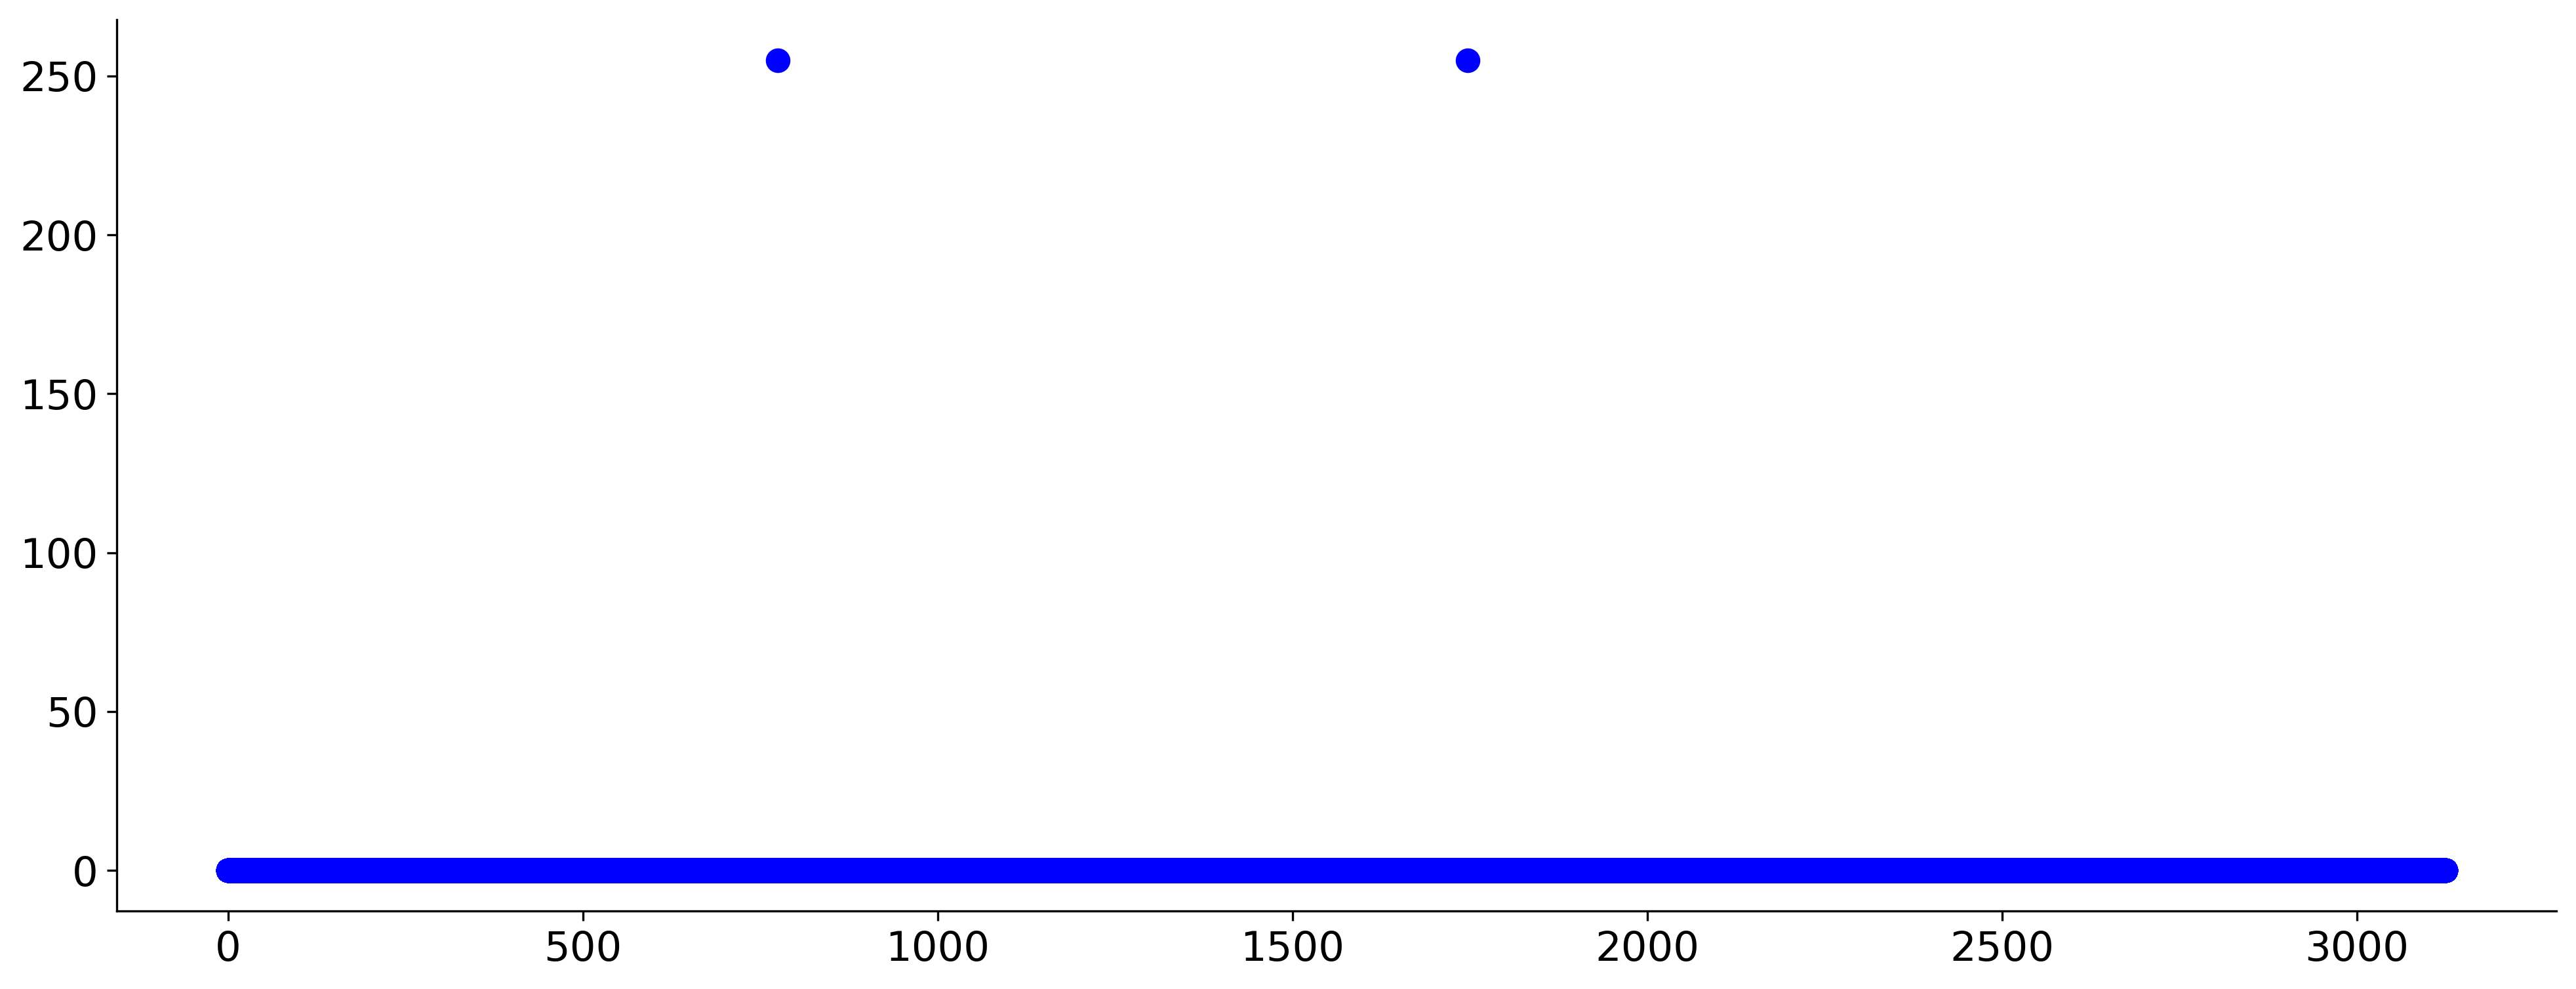

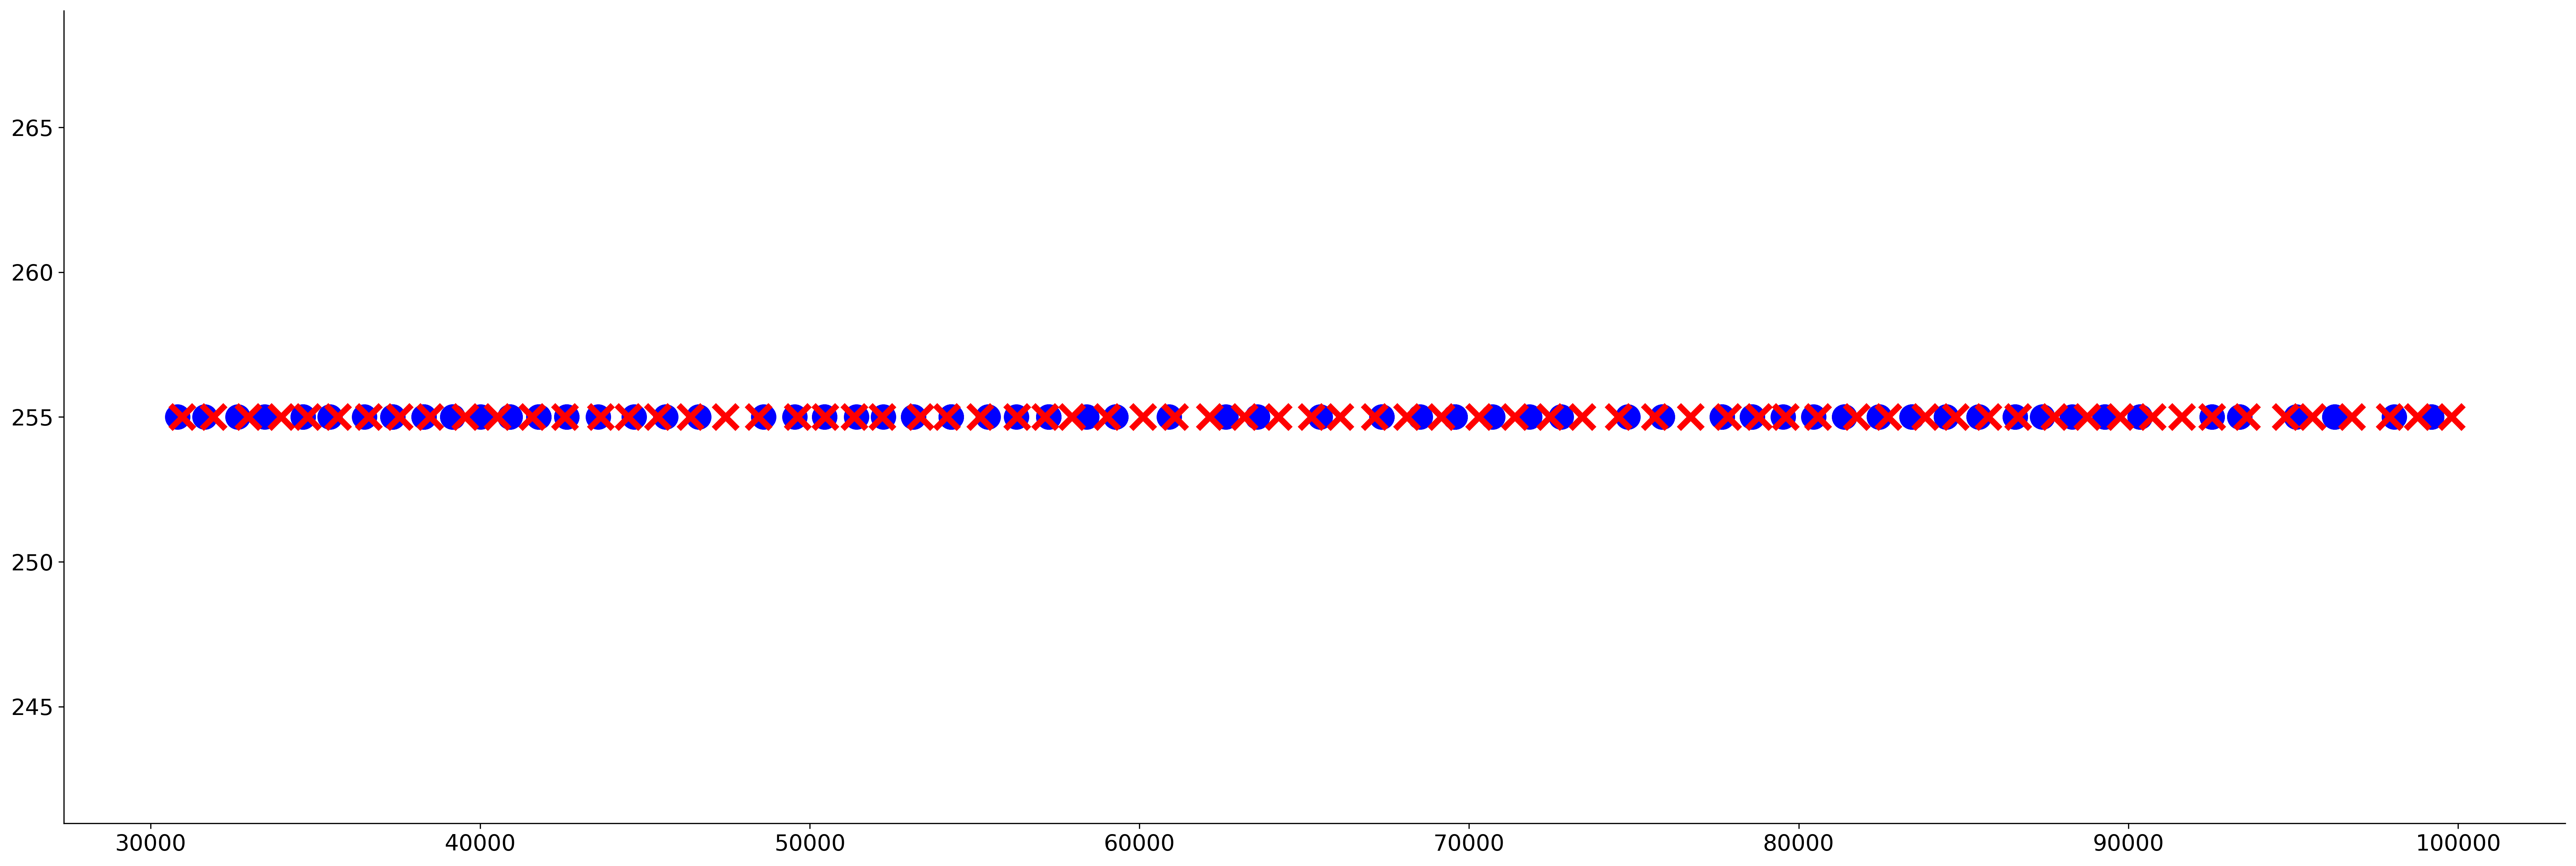

In [2]:
subj_sess = 'U554_ses0'

# Load the sync channel.
# sync_chan = events_preproc.load_syncs(subj_sess, data_key='data')
sync_chan, TTL, timestamp_flag = events_preproc.load_syncs(subj_sess, data_key='data')

if not timestamp_flag: 
     
    # Read events file and get event synctimes.
    events, event_synctimes = events_preproc.read_events_json( subj_sess )

    # Load LFP timestamps. LFP timestamps must be in msec
    lfp_timestamps, sr = spike_sorting.load_lfp_timestamps( subj_sess )

    # Identify sync pulses in the sync channel EEG. The sync channel EEG is typically sampled at a different rate than the physiological EEG.
    pulse_startinds = events_preproc.find_pulse_starts(sync_chan, 
                                                       sampling_rate=sr, 
                                                       pulse_thresh=200, 
                                                       intrapulse_thresh_ms=20, 
                                                       interpulse_thresh_ms=790
                                                      )
    
    lfp_synctimes = lfp_timestamps[pulse_startinds]
    
    print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

    subj, sess = subj_sess.split('_')
    sync_f = os.path.join('/home1/cjmac/projects/time_cells', 'data', subj, sess, 'sync', 'sync_channel_micro.mat')


    # Find matching sync pulse pairs.
    event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                             lfp_synctimes, 
                                                                             step=5, 
                                                                             max_shift=200, 
                                                                             max_slide=50, 
                                                                             ipi_thresh=2
                                                                            )
    # Perform the alignment.
    alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                                 lfp_synctimes_adj)
    
    # Apply the alignment to all event times.
    events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))    
    
    plot_flag = 0     
    if (plot_flag):
        # How did our alignment go?
        print('{} event sync pulses'.format(len(event_synctimes_adj)))
        print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
        print('\n--------------------\nAlignment parameters\n--------------------')
        for k, v in alignment.items():
            print('{}: {}'.format(k, v))

        plt.close()
        fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
        ax = np.ravel(ax)

        min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
        start = 0
        stop = None

        i = 0
        ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
        ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
        ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
        ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

        i = 1
        ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
        ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
        ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
        ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
        ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

        i = 2
        ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
        ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
        ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
        ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

        for i in range(len(ax)):
            ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
        fig.tight_layout()

        event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
        event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                                      if x<len(lfp_timestamps)])).astype(np.int64)
        event_pulse_startinds_train = np.zeros(len(sync_chan))
        event_pulse_startinds_train[event_pulse_inds] = 1

        fig, ax = plot_trace2(sync_chan, spike_dat=event_pulse_startinds_train,
                              start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)  
else:    
    # Read events file and get event synctimes in msec.
    events, event_synctimes = events_preproc.read_events_json( subj_sess, start_at_zero = True  )
    
    # Load LFP timestamps in msec
    lfp_timestamps, sr = spike_sorting.load_lfp_timestamps( subj_sess, start_at_zero = True, conv_factor = 'infer' )

    if (True):
        #
        sync_chan_new = sync_chan.copy()
        sync_chan_new *= 1000 ; # converts to msec
        sync_chan_new = sync_chan_new - sync_chan_new[0] #sync_chan_new and sync_chan are shorter in length than lfp_timestamps bc of different sampling frequency
        TTL_new = TTL.copy()
        TTL_new[np.where(TTL != 255)] = 0
        from scipy import interpolate
        f = interpolate.interp1d(sync_chan_new, TTL_new, kind = 'next', fill_value='extrapolate')
        TTL_up = f(lfp_timestamps)

        plot_flag = 1
        if plot_flag:
            ind_range_1 = [ 0, 100000 ] 
            fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=300)
            plt.plot(lfp_timestamps[ slice( ind_range_1[0], ind_range_1[1], 1)], 
                     TTL_up[ slice( ind_range_1[0], ind_range_1[1], 1)],
                     marker = 'o', color = 'blue', linestyle = 'none', markersize = 8 )

        pulse_startinds = np.where(TTL_up == 255)[0] 
        lfp_synctimes = lfp_timestamps[pulse_startinds]
        
        # 
        plot_flag = 1
        if plot_flag:
            time_range = [ 30000, 100000 ] 
            ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
            ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
            fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
            plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
                     np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
                     marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
            plt.plot(event_synctimes[ ind_event_synctimes ], 
                     np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
                     marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
            plt.show()   
    
    else:
        #
        sync_chan_new = sync_chan.copy()
        sync_chan_new /= 1000  # converts to msec
#         sync_chan_new = sync_chan_new - sync_chan_new[0] # zero the timestamps
        TTL_up = TTL.copy()
        pulse_startinds = np.where(TTL_up == 1)[0] 
        lfp_synctimes = sync_chan_new[pulse_startinds]
        event_synctimes = event_synctimes[2000:]

In [3]:
plot_flag = 0
if plot_flag:
    time_range = [ 30000, 100000 ] 
    ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
    ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
    fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
    plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
             np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
             marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
    plt.plot(event_synctimes[ ind_event_synctimes ], 
             np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
             marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
    plt.show()  
    
# need a way to check (a) if time is in UNIX time or ? AND (b) if UNIX time is in us, ms, or s.

plot_flag = 0
# Creating histogram
if plot_flag:
    fig, ax = plt.subplots(figsize=[8, 8], sharex = 'col', sharey = 'row')
    ax = plt.subplot(2, 1, 1)
    ax.hist(np.diff(event_synctimes), bins = range(0, 2000, 10))
    ax = plt.subplot(2, 1, 2)
    ax.hist(np.diff(lfp_synctimes), bins = range(0, 2000, 10))   
    
# 
plot_flag = 0
if plot_flag:
    time_range = [ 30000, 50000 ] 
    ind_lfp_synctimes = np.where(np.logical_and(lfp_synctimes>=time_range[0], lfp_synctimes<=time_range[1]))
    ind_event_synctimes= np.where(np.logical_and(event_synctimes>=time_range[0], event_synctimes<=time_range[1]))
    fig, ax = plt.subplots(1, 1, figsize=(30, 10), dpi=300)
    plt.plot(lfp_synctimes[ ind_lfp_synctimes ], 
             np.full( ( 1, len( ind_lfp_synctimes[0] ) ), 255 )[0],
             marker = 'o', color = 'blue', linestyle = 'none', markersize = 16 ) 
    plt.plot(event_synctimes[ ind_event_synctimes ], 
             np.full( ( 1, len( ind_event_synctimes[0] ) ), 255 )[0],
             marker = 'x', color = 'red', linestyle = 'none', mew = 4, markersize = 16 ) 
    plt.show()  
    
#
print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

subj, sess = subj_sess.split('_')
sync_f = os.path.join('/home1/cjmac/projects/time_cells', 'data', subj, sess, 'sync', 'sync_channel_micro.mat')

Detected 6053 syncs for 4732 sync pulse events


In [4]:
# Find matching sync pulse pairs.
event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                         lfp_synctimes, 
                                                                         step=5, 
                                                                         max_shift=250, 
                                                                         max_slide=50, 
                                                                         ipi_thresh=2
                                                                        )                                           

Loop 0: Inter-sync times failed to converge
Loop 7: Inter-sync times failed to converge
Loop 13: Inter-sync times failed to converge
Loop 17: Inter-sync times failed to converge
Loop 21: Inter-sync times failed to converge
Loop 22: Inter-sync times failed to converge
Loop 24: Inter-sync times failed to converge
Loop 26: Inter-sync times failed to converge
Loop 27: Inter-sync times failed to converge
Loop 46: Inter-sync times failed to converge
Loop 50: Inter-sync times failed to converge
Loop 68: Inter-sync times failed to converge
Loop 73: Inter-sync times failed to converge
Loop 81: Inter-sync times failed to converge
Loop 92: Inter-sync times failed to converge
Loop 100: Inter-sync times failed to converge
Loop 115: Inter-sync times failed to converge
Loop 137: Inter-sync times failed to converge
Loop 139: Inter-sync times failed to converge
Loop 141: Inter-sync times failed to converge
Loop 144: Inter-sync times failed to converge
Loop 148: Inter-sync times failed to converge
Loop 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


745 event sync pulses
745 LFP sync pulses identified

--------------------
Alignment parameters
--------------------
sync_params: OrderedDict([('intercept', 42906.21614721467), ('slope', 1.000019956452069)])
before_stats: OrderedDict([('ipi_r', 0.9999999998329058), ('ipi_diff', 0.3065599010836694), ('rmse', 42954.0651978533), ('err_pcts', 0      42908.233887
1      42909.000518
5      42912.477734
10     42917.772412
25     42933.095215
50     42954.729492
75     42973.308105
90     42990.991504
95     42994.314404
99     42998.396230
100    42999.402832
dtype: float64)])
after_stats: OrderedDict([('ipi_r', 0.999999999832906), ('ipi_diff', 0.23138857092017526), ('rmse', 0.22755705177105112), ('err_pcts', 0      0.000016
1      0.002461
5      0.016695
10     0.032621
25     0.079304
50     0.159187
75     0.267657
90     0.372845
95     0.433645
99     0.568807
100    0.793870
dtype: float64)])
sync_pairs: [[  93598.27001953  136506.72607422]
 [  94766.42993164  137674.97509766]
 [  95

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


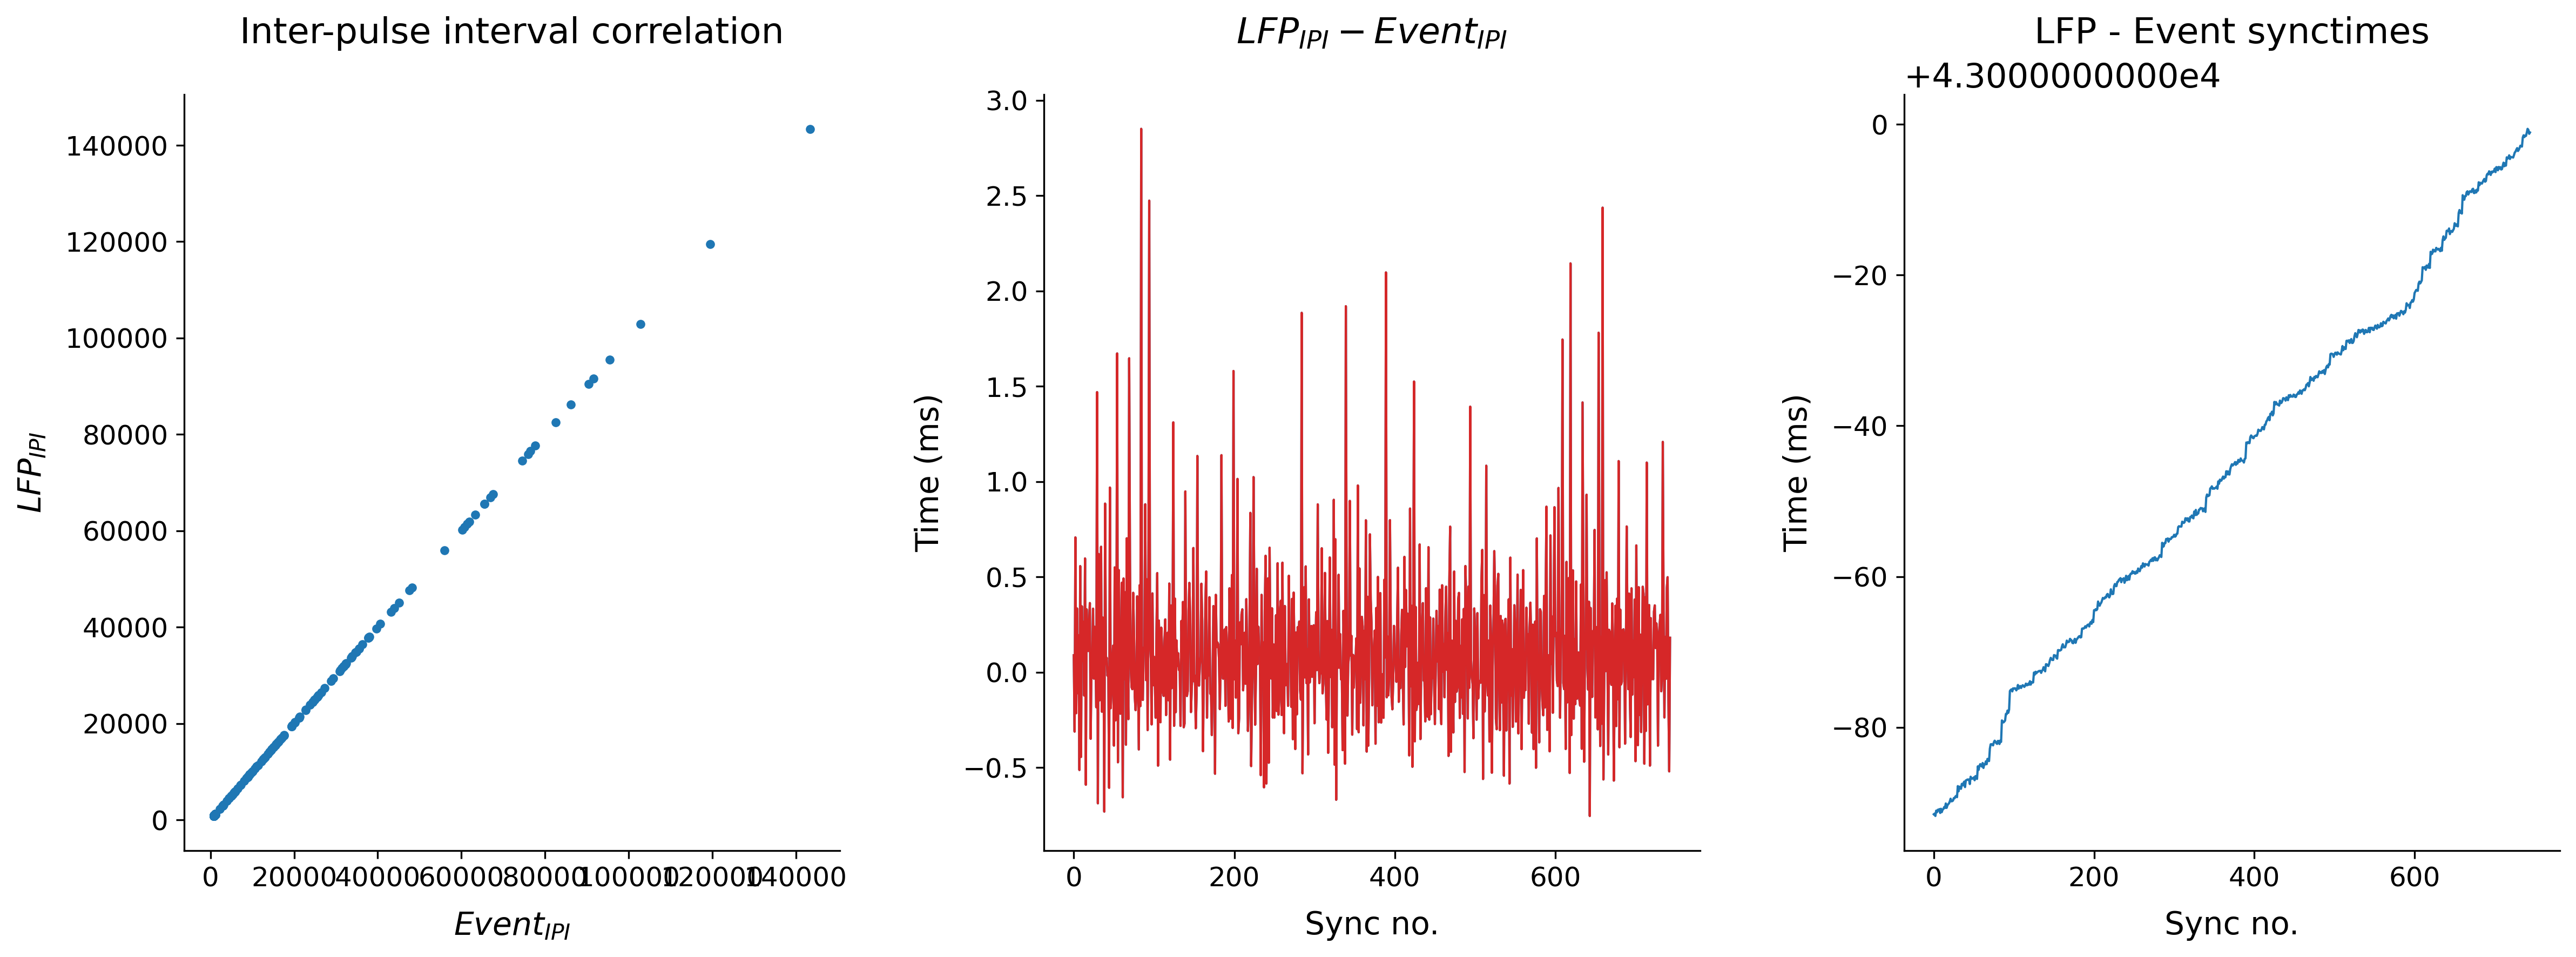

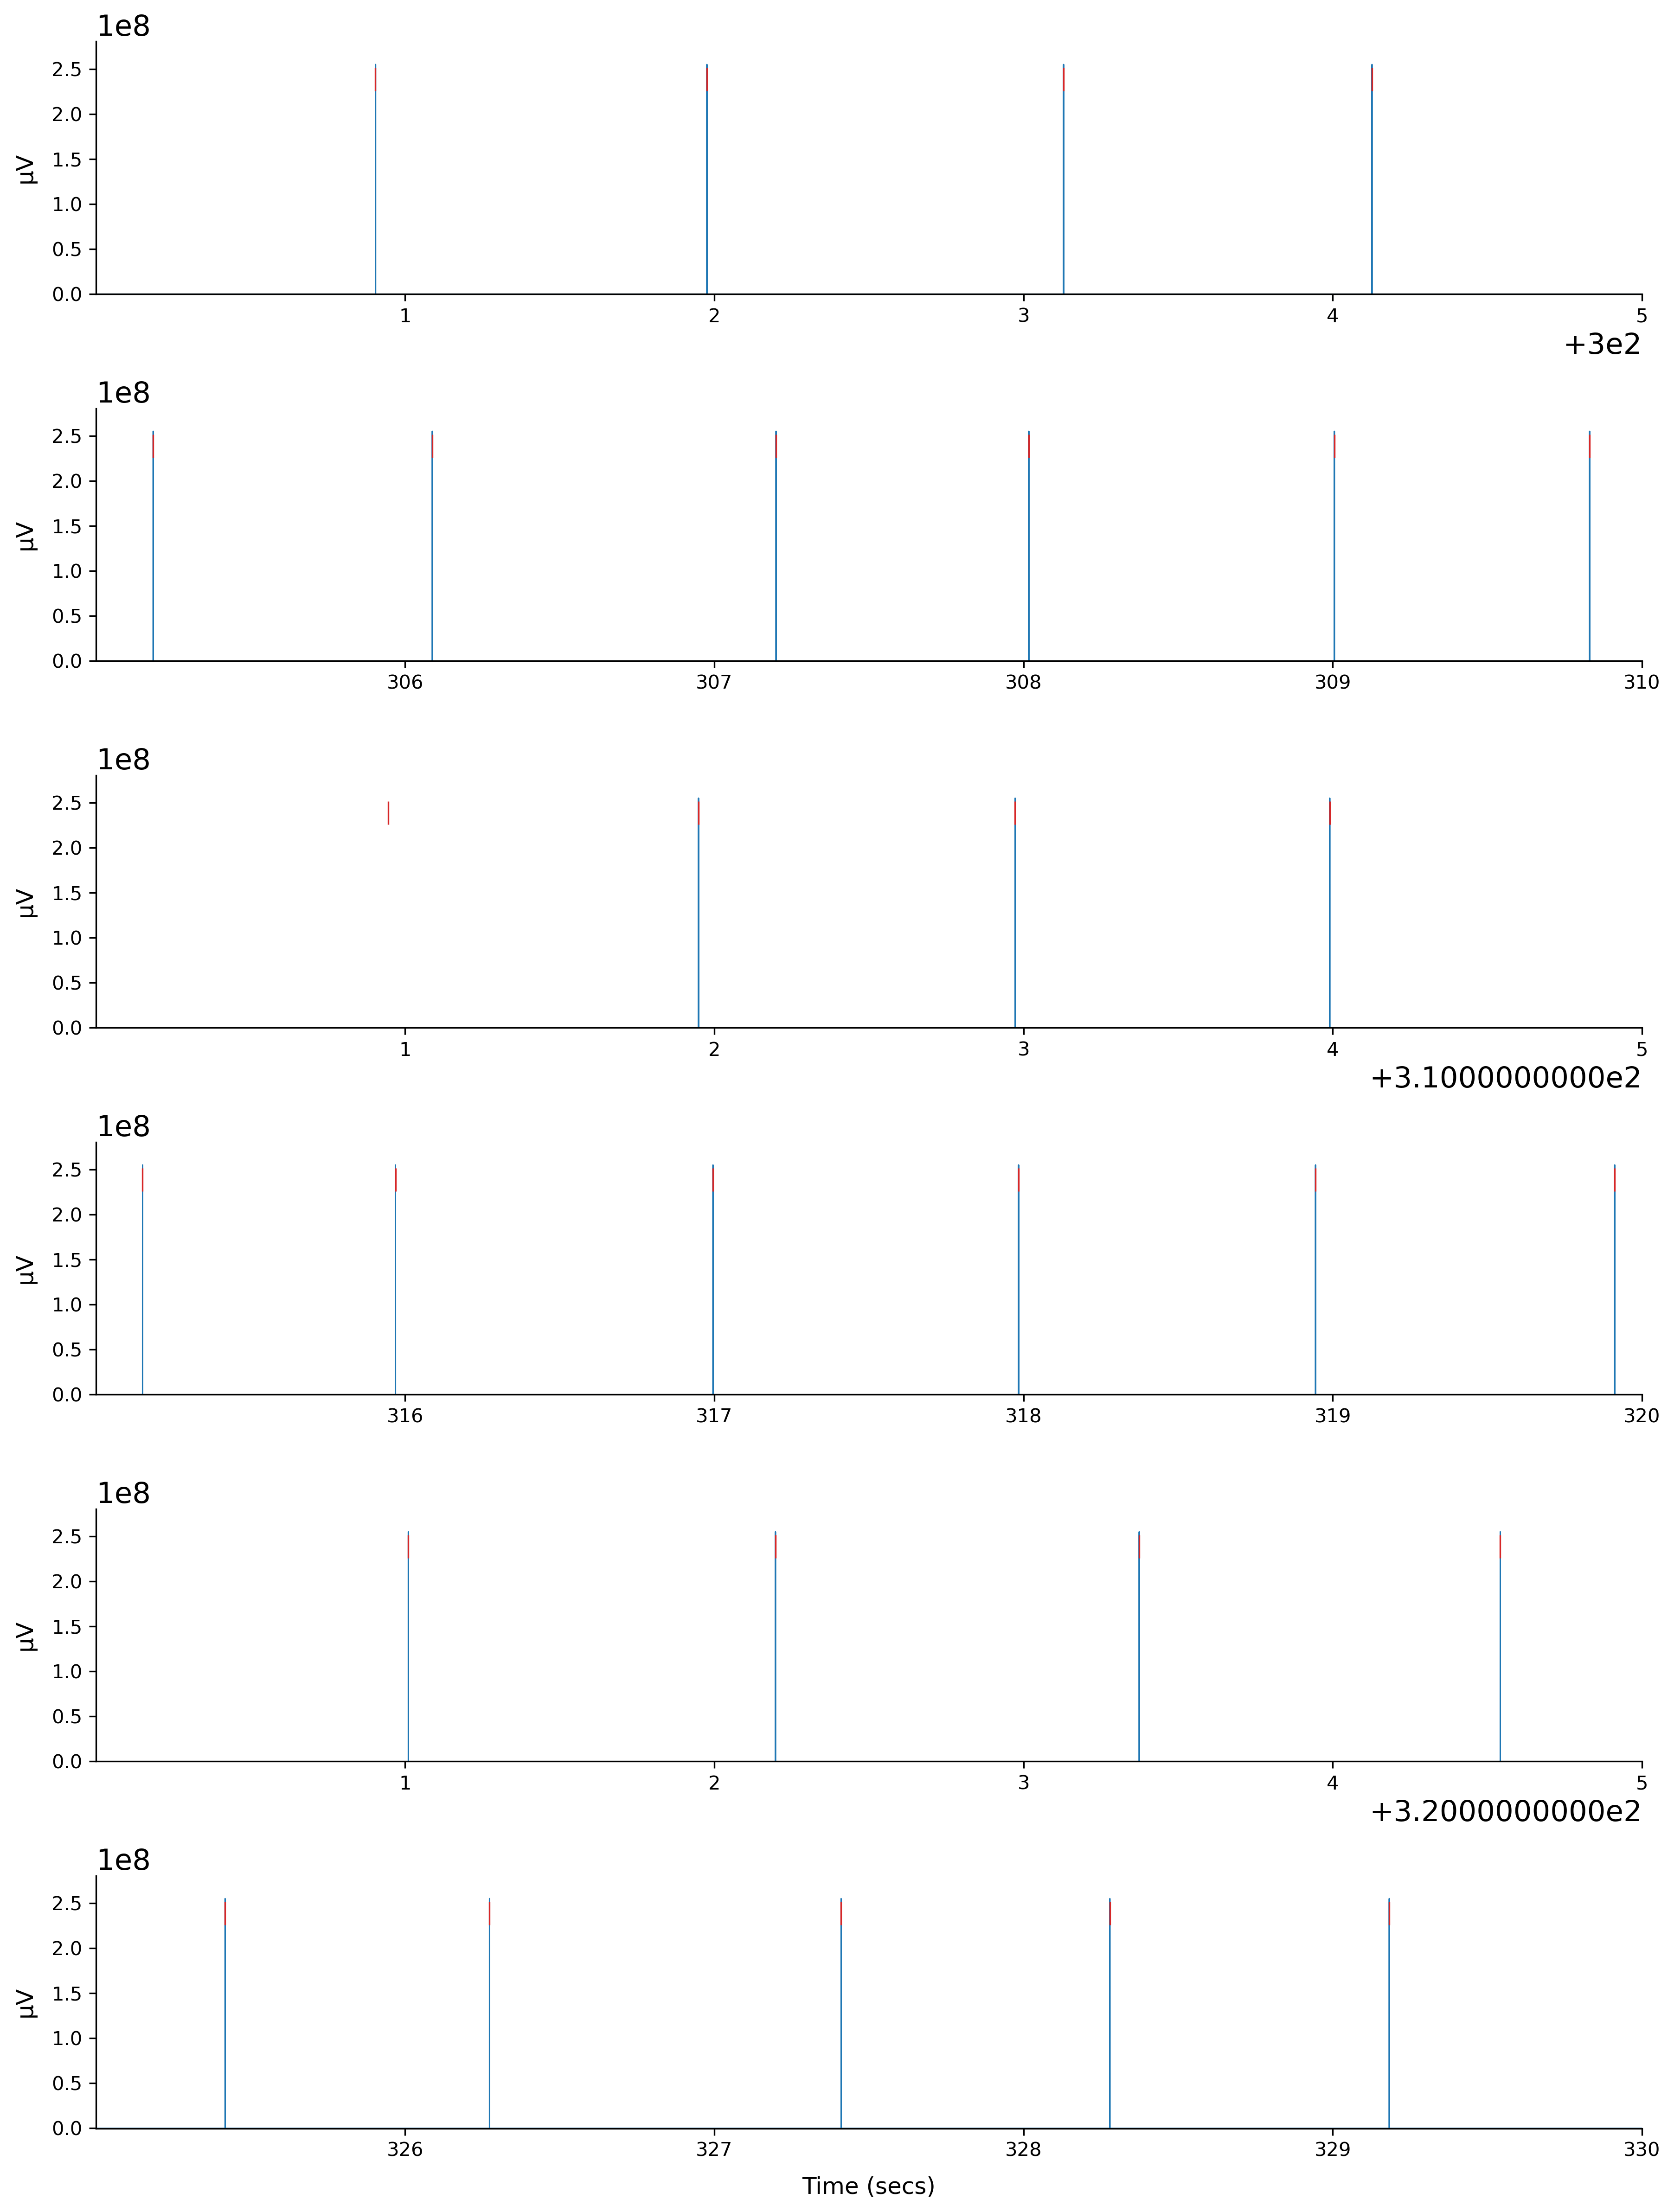

In [5]:
# Perform the alignment.
alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                             lfp_synctimes_adj)

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))

# events.to_csv('./outputs/csv/events_all_adj.csv')
events.loc[events.key == 'syncPulse'].to_csv('./outputs/csv/events_all_adj_synctimes.csv')

# # cjm addition
# events['time'] = (events['time'] - events.at[0, 'time'])

plot_flag = 1    
if (plot_flag):

    # How did our alignment go?
    print('{} event sync pulses'.format(len(event_synctimes_adj)))
    print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
    print('\n--------------------\nAlignment parameters\n--------------------')
    for k, v in alignment.items():
        print('{}: {}'.format(k, v))

    plt.close()
    fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
    ax = np.ravel(ax)

    min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
    start = 0
    stop = None

    i = 0
    ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
    ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
    ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

    i = 1
    ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
    ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
    ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
    ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

    i = 2
    ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
    ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
    ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
    ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

    for i in range(len(ax)):
        ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
    fig.tight_layout()    

    event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
    event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                                  if x<len(lfp_timestamps)])).astype(np.int64)
    event_pulse_startinds_train = np.zeros(len(lfp_timestamps))
    event_pulse_startinds_train[event_pulse_inds] = 1

    fig, ax = plot_trace2(TTL_up, spike_dat=event_pulse_startinds_train,
                          start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)


## Format events and spikes

In [6]:
proc_events = True
proc_spikes = True
proj_dir = '/home1/cjmac/projects/time_cells'
subj_sess = 'U554_ses0'
run_all = True
save_output = True
overwrite = True
verbose = True

start_time = time()
warnings.filterwarnings('ignore')

print(subj_sess)
if proc_events:
    # Load events and event times.
    print('Processing events data.', end='\n\n')
    events = events_preproc.format_events(events=events,
                                          noisy_trials=[],
                                          remove_incomplete_trials=True,
                                          remove_noisy_trials=False,
                                          remove_paused_trials=False,
                                          overwrite=overwrite,
                                          save_output=save_output,
                                          proj_dir=proj_dir,
                                          verbose=verbose)

    events = events_proc.load_events(subj_sess,
                                     proj_dir=proj_dir,
                                     overwrite=overwrite,
                                     verbose=verbose,
                                     run_all=run_all)

    if save_output:
        events_proc.save_events(events,
                                overwrite=overwrite,
                                verbose=verbose)

U554_ses0
Processing events data.

Processing trial 1 and game state Delay
Processing trial 1 and game state ReturnToBase
Processing trial 2 and game state Delay
Processing trial 2 and game state ReturnToBase
Processing trial 3 and game state Delay
Processing trial 3 and game state ReturnToBase
Processing trial 4 and game state Delay
Processing trial 4 and game state ReturnToBase
Processing trial 5 and game state Delay
Processing trial 5 and game state ReturnToBase
Processing trial 6 and game state Delay
Processing trial 6 and game state ReturnToBase
Processing trial 7 and game state Delay
Processing trial 7 and game state ReturnToBase
Processing trial 8 and game state Delay
Processing trial 8 and game state ReturnToBase
Processing trial 9 and game state Delay
Processing trial 9 and game state ReturnToBase
Processing trial 10 and game state Delay
Processing trial 10 and game state ReturnToBase
Processing trial 11 and game state Delay
Processing trial 11 and game state ReturnToBase
Proc

In [7]:
if proc_spikes:
    # Load spikes.
    print('Processing spikes data.', end='\n\n')
    spikes = spike_preproc.format_spikes(subj_sess,
                                         conv_factor='infer',
                                         fr_thresh=0.1,
                                         overwrite=True,
                                         save_output=True,
                                         split_files=True,
                                         verbose=verbose)

# warnings.resetwarnings()
# print('Done in {:.2f} s'.format(time() - start_time))

savefile = False
overwrite = False

event_spikes = time_bin_analysis.load_event_spikes(subj_sess, overwrite=overwrite)
if savefile:
    time_bin_analysis.save_event_spikes(event_spikes, overwrite=overwrite)

savefile = True
overwrite = True

event_spikes = time_bin_analysis.load_event_spikes(subj_sess, overwrite=overwrite)
if savefile:
    time_bin_analysis.save_event_spikes(event_spikes, overwrite=overwrite)

Processing spikes data.

The first timestamp in lfp_timestamps before zero-ing & before conv factor is 1654709925.092
The first timestamp in lfp_timestamps before zero-ing & after conv factor is 1654709925091.791
The first timestamp in lfp_timestamps after zero-ing & conv factor is 0.000
Conversion factor is 1000.0
153210591 timestamps over 79 min and 47.8 s
Sampling rate is 32000 Hz
Found 80 wave_clus files.

Found 28 neurons
Firing rates:
count    28.000000
mean      0.825314
std       1.083380
min       0.105476
25%       0.210847
50%       0.391514
75%       0.939413
max       4.795702
Name: fr, dtype: float64

        unit  chan        fr
hemroi                      
LEC        1     1  0.105476
LMH        2     2  1.046403
LP         5     3  0.410833
LSFG       2     2  0.245310
RA         4     4  0.563930
REC        1     1  0.684444
RFSG       9     4  0.244996
RMH        2     2  0.970168
RS7G       2     1  3.273926
Saved /home1/cjmac/projects/time_cells/analysis/spikes/U55

In [14]:
def model_unit_fr_parallel(subj_sess_neuron):
    import sys
    import os
    from time import sleep
    import numpy as np
    sys.path.append('/home1/cjmac/code/projects')
    from time_cells.time_bin_analysis import model_unit_fr
    
    # Take a nap.
    if False:
        sleep_secs = int(1800 * np.random.rand())
        sleep(sleep_secs)
    try:
        subj_sess, chan, unit = subj_sess_neuron.split('-')
        neuron = '{}-{}'.format(chan, unit)
        output = model_unit_fr(subj_sess,
                               neuron,
                               model='ols',
                               n_perm=1000,
                               overwrite=False,
                               save_output=True)
    except:
        err = sys.exc_info()
        errf = '/home1/cjmac/logs/TryExceptError-model_unit_fr_parallel-{}'.format(subj_sess_neuron)
        os.system('touch {}'.format(errf))
        with open(errf, 'w') as f:
            f.write(str(err) + '\n')
    
    return None

start_time = time()

# Load event_spikes and get the names of each neuron.
proj_dir = '/home1/cjmac/projects/time_cells'

# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

3 subjects, 3 sessions


In [15]:
subj_sess_neurons = []
for subj_sess in sessions:
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    for neuron in event_spikes.column_map['neurons']:
        subj_sess_neuron = '{}-{}'.format(subj_sess, neuron)
        #output_f = op.join(proj_dir, 'analysis', 'behav_glms', '{}-glm_results.pkl'.format(subj_sess_neuron))
        output_f = op.join(proj_dir, 'analysis', 'unit_to_behav', '{}-ols-time_bin-model_pairs.pkl'.format(subj_sess_neuron))
        if not op.exists(output_f):
            subj_sess_neurons.append(subj_sess_neuron)
print('{} neurons'.format(len(subj_sess_neurons)))

AssertionError: 

In [10]:
# Parallel processing
for subj_sess_neuron in subj_sess_neurons:
    _start_time = time()
    print(subj_sess_neuron)
    _ = model_unit_fr_parallel(subj_sess_neuron)
    print('{:.1f}s'.format(time() - start_time))

print('Done in {:.1f}s')

In [10]:
def model_unit_fr_parallel(subj_sess_neuron):
    import sys
    import os
    from time import sleep
    import numpy as np
    sys.path.append('/home1/cjmac/code/projects')
    from time_cells.time_bin_analysis import model_unit_fr
    # Take a nap.
    if False:
        sleep_secs = int(1800 * np.random.rand())
        sleep(sleep_secs)
    try:
        subj_sess, chan, unit = subj_sess_neuron.split('-')
        neuron = '{}-{}'.format(chan, unit)
        output = model_unit_fr(subj_sess,
                               neuron,
                               model='ols',
                               n_perm=1000,
                               overwrite=True,
                               save_output=True)
    except:
        err = sys.exc_info()
        errf = '/home1/cjmac/logs/TryExceptError-model_unit_fr_parallel-{}'.format(subj_sess_neuron)
        os.system('touch {}'.format(errf))
        with open(errf, 'w') as f:
            f.write(str(err) + '\n')
    
    return None

# from importlib import reload
# flag_reload = 1
# if flag_reload:
#     reload( time_bin_analysis )

start_time = time()

# Load event_spikes and get the names of each neuron.
proj_dir = '/home1/cjmac/projects/time_cells'

# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
sessions = np.delete(sessions, 0)
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

2 subjects, 2 sessions


In [13]:
subj_sess_neurons = []
for subj_sess in sessions:
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    for neuron in event_spikes.column_map['neurons']:
        subj_sess_neuron = '{}-{}'.format(subj_sess, neuron)
        output_f = op.join(proj_dir, 'analysis', 'behav_glms', '{}-glm_results.pkl'.format(subj_sess_neuron))
        #output_f = op.join(proj_dir, 'analysis', 'unit_to_behav', '{}-ols-time_bin-model_pairs.pkl'.format(subj_sess_neuron))
        print(output_f)
        if not op.exists(output_f):
            subj_sess_neurons.append(subj_sess_neuron)
    print('{} neurons'.format(len(subj_sess_neurons)))

/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-13-1-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-15-1-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-18-1-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-45-1-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-36-1-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-46-1-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-55-1-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-56-1-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-66-1-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-66-2-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-73-1-glm_results.pkl
/home1/cjmac/projects/time_cells/analysis/behav_glms/U554_ses0-76-1-glm_resu

AssertionError: 

In [12]:
# cjm change
subj_sess_neurons = ['U554_ses0-46-1']

# # cjm change
if False:
    subj_sess_neurons = [which_neuron for which_neuron in subj_sess_neurons if which_neuron in [ 'U554_ses0-46-1' ] ]

## Section to understand how OLS fitting was done in time_bin_analysis.py

In [ ]:
df = event_spikes.event_spikes.query("(gameState=='{}')".format('Retrieval')).copy()
neuron = '46-1'
keep_cols = ['trial', 'gameState', 'time_step', 'maze_region', 'head_direc', 'is_moving', 
             'base_in_view', 'gold_in_view', 'dig_performed', neuron]
df = df[keep_cols]
dummys = ['is_moving', 'base_in_view', 'gold_in_view', 'dig_performed']
df[dummys] = df[dummys].fillna(0)
df.to_csv('mdl_46-1.csv')
regress_trial = False
trial_term = ' + C(trial)' if regress_trial else ''
formulas = od([])
formulas['full']          = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subtime']  = "Q('{}') ~ 1                + C(maze_region) + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subplace'] = "Q('{}') ~ 1 + C(time_step)                  + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subhd']    = "Q('{}') ~ 1 + C(time_step) + C(maze_region)                 + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_submvmt']  = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc)             + base_in_view + dig_performed{}".format(neuron, trial_term)
formulas['full_subbiv']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving                + dig_performed{}".format(neuron, trial_term)
formulas['full_subdig']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view                {}".format(neuron, trial_term)
mod_names = list(formulas.keys())
df2 = df[['trial', 'gameState', 'maze_region', '46-1']].to_csv('mdl_place_46-1.csv')

## Section to organize spiking data into a table to determin the # spikes per maze segment.

In [ ]:
all_neurons = event_spikes.column_map.get('neurons')
which_neuron = all_neurons[5]
keep_cols = ['trial', 'gameState', 'time_step', 'maze_region', 'head_direc', 'is_moving', 
             'base_in_view', 'gold_in_view', 'dig_performed', which_neuron]
rows = {'gameState':'Encoding'}
df = get_df_subset(event_spikes.event_spikes.copy(), columns = keep_cols, rows = rows)
df

# df.insert(4, 'duration', df['stop_time']-df['start_time'])
# df = df.drop(columns=['start_time', 'stop_time'])

# Let's print the first entries
# in all the groups formed.
df_group = df.groupby(['maze_region']).sum()
df_group.insert(3, 'rate', df_group[which_cell]/df_group['duration']*1000)
df_group

In [ ]:
if True:
    reload(time_bin_analysis)

# Parallel processing
for subj_sess_neuron in subj_sess_neurons:
    _start_time = time()
    print(subj_sess_neuron)
    _ = model_unit_fr_parallel(subj_sess_neuron)
    print('{:.1f}s'.format(time() - start_time))

print('Done in {:.1f}s')

In [ ]:
# subj_sess_neurons = subj_sess_neurons[23]
subj_sess_neurons

In [ ]:
# import pickle

with open('U554_ses0-46-1-ols-time_bin-model_pairs.pkl', 'rb') as f:
    data = pickle.load(f)

# %cd /home1/cjmac/projects/time_cells/analysis/unit_to_behav

In [ ]:
data